In [1]:
import azureml.core
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Experiment, Workspace

# Check core SDK version number
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")
print("")

# Log In to Azure ML Workspace
interactive_auth = InteractiveLoginAuthentication(tenant_id="76f90eb1-fb9a-4446-9875-4d323d6455ad")

ws = Workspace.from_config(auth=interactive_auth)
print('Workspace name: ' + ws.name, sep='\n')

You are currently using version 1.8.0 of the Azure ML SDK

Workspace name: team20


In [2]:
from azureml.core import Dataset
aml_dataset = Dataset.get_by_name(ws, 'train_ds', version='latest')
data = aml_dataset.to_pandas_dataframe()

/anaconda/envs/py37_default/lib/python3.7/site-packages/azureml/dataprep/api/dataflow.py:722: UserWarning: Your pandas and pyarrow versions are incompatible. Please install pyarrow>=0.12.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install pyarrow>=0.12.0 --upgrade
  warnings.warn('Your pandas and pyarrow versions are incompatible. '


In [3]:
data.head()

,CardHolder,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,...,sale_sum_6m_g24,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m
0,16095858,47.0,3.0,22.0,19.0,3.0,28.0,8.0,7.0,6.0,...,3141.25,356.67,237.25,283.84,3648.23,1195.37,535.42,1.7078,0.2798,0.3008
1,15906620,57.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,...,113.39,62.69,58.71,87.01,179.83,0.00,122.98,0.0000,0.0000,0.0000
2,16495466,38.0,7.0,0.0,15.0,4.0,9.0,5.0,9.0,14.0,...,1239.19,533.46,83.37,593.13,1217.43,1336.83,3709.82,0.0000,NaN,0.0803
3,16570217,65.0,6.0,3.0,25.0,2.0,10.0,14.0,11.0,8.0,...,139.68,1849.91,360.40,175.73,496.73,172.58,1246.21,0.0000,0.0000,0.0000
4,16346871,61.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,3.0,...,226.98,168.05,461.37,0.00,237.93,225.51,995.27,1.4142,0.3495,0.3495


In [4]:
data = aml_dataset.to_pandas_dataframe()
data_backup = data.copy()

/anaconda/envs/py37_default/lib/python3.7/site-packages/azureml/dataprep/api/dataflow.py:722: UserWarning: Your pandas and pyarrow versions are incompatible. Please install pyarrow>=0.12.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install pyarrow>=0.12.0 --upgrade
  warnings.warn('Your pandas and pyarrow versions are incompatible. '


In [5]:
data = data_backup.copy()

In [59]:
import modin.pandas as pd
import numpy as np

data.set_index('CardHolder', drop=True, inplace=True)
data['group'].replace({'test': 1, 'control': 0}, inplace=True)
data['gender'].replace({'Ж': 0, 'М': 1, 'Не определен': np.NaN}, inplace=True)

In [14]:
import xgboost
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, stratify=data['response_att'],
                                   shuffle=True)


In [17]:
params = {'n_estimators': 20, 'eval_metric': ['logloss', 'auc', 'error'], 'verbose': True, 'n_jobs': -1}
model = xgboost.XGBClassifier(**params)

X_train = train.drop('response_att', axis=1)
y_train = train['response_att']

X_test = test.drop('response_att', axis=1)
y_test = test['response_att']

In [18]:
model.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.630031	validation_0-auc:0.766055	validation_0-error:0.105963
[1]	validation_0-logloss:0.578451	validation_0-auc:0.774827	validation_0-error:0.105869
[2]	validation_0-logloss:0.535591	validation_0-auc:0.775505	validation_0-error:0.105694
[3]	validation_0-logloss:0.499767	validation_0-auc:0.780539	validation_0-error:0.104879
[4]	validation_0-logloss:0.469424	validation_0-auc:0.783665	validation_0-error:0.104843
[5]	validation_0-logloss:0.443672	validation_0-auc:0.784574	validation_0-error:0.10485
[6]	validation_0-logloss:0.42176	validation_0-auc:0.784848	validation_0-error:0.105025
[7]	validation_0-logloss:0.402891	validation_0-auc:0.784957	validation_0-error:0.105003
[8]	validation_0-logloss:0.386719	validation_0-auc:0.785164	validation_0-error:0.104792
[9]	validation_0-logloss:0.372762	validation_0-auc:0.784819	validation_0-error:0.104864
[10]	validation_0-logloss:0.36075	validation_0-auc:0.784801	validation_0-error:0.104886
[11]	validation_0-logloss:0.350381

XGBClassifier(eval_metric=['logloss', 'auc', 'error'], n_estimators=20,
              n_jobs=-1, verbose=True)

In [23]:
def importances(train, model):
    cols = list(train.drop('response_att', axis=1).columns)

    feats = pd.Series(data=model.feature_importances_, index=cols) 
    feats.sort_values(ascending=False, inplace=True)
    print(feats.head(20))

In [24]:
importances(train, model)

k_var_days_between_visits_1m           0.317405
perdelta_days_between_visits_15_30d    0.212026
k_var_days_between_visits_15d          0.152806
stdev_days_between_visits_15d          0.049486
k_var_days_between_visits_3m           0.042280
cheque_count_6m_g40                    0.034235
cheque_count_6m_g32                    0.028553
cheque_count_12m_sum                   0.028277
cheque_count_6m_g41                    0.018373
cheques_per_child                      0.016887
k_var_disc_share_3m_g24                0.016651
cheque_count_12m_g48                   0.013941
food_share_1m                          0.013861
cheque_count_6m_g25                    0.012009
cheque_count_12m_g32                   0.011357
months_from_register                   0.008419
k_var_disc_per_cheque_15d              0.008339
food_share_15d                         0.007714
k_var_sku_price_6m_max                 0.007381
k_var_count_per_cheque_1m_g24          0.000000
dtype: float32


In [29]:
pred = model.predict_proba(X_test)

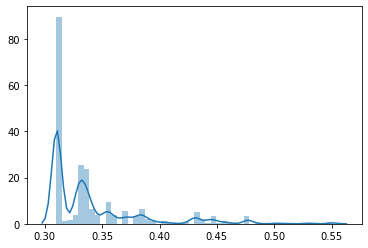

In [31]:
import seaborn as sns
sns.distplot(pred[:,1])

In [36]:
train1 = X_train[y_train == 1]
train0 = X_train[y_train == 0]

In [63]:
cols = list(train.drop('response_att', axis=1).columns)

feats = pd.Series(data=model.feature_importances_, index=cols) 
feats.sort_values(ascending=False, inplace=True)
feats.head(15)

k_var_days_between_visits_15d          0.466894
k_var_days_between_visits_1m           0.211764
perdelta_days_between_visits_15_30d    0.145268
stdev_days_between_visits_15d          0.053817
cheque_count_6m_g40                    0.036728
k_var_days_between_visits_3m           0.032206
cheque_count_12m_g32                   0.016181
cheque_count_6m_g48                    0.015134
cheque_count_12m_g48                   0.014948
k_var_cheque_15d                       0.007059
k_var_sku_price_1m_g49                 0.000000
k_var_sku_price_1m_g54                 0.000000
k_var_sku_price_1m_g44                 0.000000
k_var_sku_price_3m_g24                 0.000000
k_var_sku_price_3m_g26                 0.000000
dtype: float32

In [9]:
import sys
sys.path.append('../features')

In [10]:
from functions import preprocessing

In [69]:
data = data_backup.copy()

In [12]:
import numpy as np
import pandas as pd

In [13]:
data = data_backup.copy()
full_prep(data)

In [6]:
def full_prep(data):
    preprocessing(data)
    data['group'].replace({'test': 1, 'control': 0}, inplace=True)
    data['gender'].replace({'Ж': 0, 'М': 1, 'Не определен': np.NaN}, inplace=True)

In [27]:
data['group']

0         1
1         1
2         0
3         1
4         1
         ..
687024    0
687025    1
687026    0
687027    0
687028    1
Name: group, Length: 687029, dtype: int64

In [28]:
data['class'] = 0
data.loc[(data['group'] == 0) & (data['response_att'] == 1), 'class'] = 1
data.loc[(data['group'] == 1) & (data['response_att'] == 0), 'class'] = 2
data.loc[(data['group'] == 1) & (data['response_att'] == 1), 'class'] = 3

In [40]:
#y = data['class']
#data.drop(['group', 'response_att', 'class'], axis=1, inplace=True)

x_train, x_test, y_train, y_test = train_test_split(data, y)

In [38]:
y_test.shape

(171758,)

In [42]:
params = {'n_estimators': 20, 'eval_metric': ['merror', 'mlogloss'], 'verbose': True, 'n_jobs': -1}
model = xgboost.XGBClassifier(**params)

model.fit(x_train, y_train, verbose=True, eval_set=[(x_test, y_test)])

[0]	validation_0-merror:0.331053	validation_0-mlogloss:1.31556
[1]	validation_0-merror:0.327205	validation_0-mlogloss:1.25633
[2]	validation_0-merror:0.323688	validation_0-mlogloss:1.20557
[3]	validation_0-merror:0.323199	validation_0-mlogloss:1.16216
[4]	validation_0-merror:0.323135	validation_0-mlogloss:1.12503
[5]	validation_0-merror:0.323199	validation_0-mlogloss:1.09279
[6]	validation_0-merror:0.322978	validation_0-mlogloss:1.06471
[7]	validation_0-merror:0.322949	validation_0-mlogloss:1.04022
[8]	validation_0-merror:0.322949	validation_0-mlogloss:1.01869
[9]	validation_0-merror:0.322809	validation_0-mlogloss:0.999763
[10]	validation_0-merror:0.322547	validation_0-mlogloss:0.983014
[11]	validation_0-merror:0.322553	validation_0-mlogloss:0.96819
[12]	validation_0-merror:0.322227	validation_0-mlogloss:0.954936
[13]	validation_0-merror:0.322168	validation_0-mlogloss:0.943311
[14]	validation_0-merror:0.322203	validation_0-mlogloss:0.932988
[15]	validation_0-merror:0.322104	validation_

XGBClassifier(eval_metric=['merror', 'mlogloss'], n_estimators=20, n_jobs=-1,
              objective='multi:softprob', verbose=True)

In [44]:
pred = model.predict_proba(x_test)

In [46]:
final = pred[:,3] + pred[:,0] - pred[:,1] - pred[:,2]

In [51]:
test['group'].replace({1: 'test', 0: 'control'}, inplace=True)
test['uplift'] = final

/anaconda/envs/py37_default/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


ValueError: Length of values does not match length of index

In [60]:
data = data_backup.copy()
data['gender'].replace({'Ж': 0, 'М': 1, 'Не определен': np.NaN}, inplace=True)
data['class'] = 0
data.loc[(data['group'] == 'control') & (data['response_att'] == 1), 'class'] = 1
data.loc[(data['group'] == 'test') & (data['response_att'] == 0), 'class'] = 2
data.loc[(data['group'] == 'test') & (data['response_att'] == 1), 'class'] = 3

train, test = train_test_split(data)

x_train = train.drop(['class', 'group', 'response_att'], axis=1)
y_train = train['class']

x_test = test.drop(['class', 'group', 'response_att'], axis=1)
y_test = test['class']

params = {'n_estimators': 20, 'eval_metric': ['merror', 'mlogloss'], 'verbose': True, 'n_jobs': -1}
model = xgboost.XGBClassifier(**params)

model.fit(x_train, y_train, verbose=True, eval_set=[(x_test, y_test)])

[0]	validation_0-merror:0.320585	validation_0-mlogloss:1.31485
[1]	validation_0-merror:0.320812	validation_0-mlogloss:1.25548
[2]	validation_0-merror:0.319991	validation_0-mlogloss:1.20466
[3]	validation_0-merror:0.320003	validation_0-mlogloss:1.16152
[4]	validation_0-merror:0.32087	validation_0-mlogloss:1.12428
[5]	validation_0-merror:0.319985	validation_0-mlogloss:1.09195
[6]	validation_0-merror:0.321342	validation_0-mlogloss:1.06382
[7]	validation_0-merror:0.321342	validation_0-mlogloss:1.03921
[8]	validation_0-merror:0.32151	validation_0-mlogloss:1.01759
[9]	validation_0-merror:0.321505	validation_0-mlogloss:0.998535
[10]	validation_0-merror:0.32151	validation_0-mlogloss:0.981738
[11]	validation_0-merror:0.321551	validation_0-mlogloss:0.966857
[12]	validation_0-merror:0.321289	validation_0-mlogloss:0.953579
[13]	validation_0-merror:0.321295	validation_0-mlogloss:0.941866
[14]	validation_0-merror:0.321289	validation_0-mlogloss:0.931473
[15]	validation_0-merror:0.321313	validation_0-

XGBClassifier(eval_metric=['merror', 'mlogloss'], n_estimators=20, n_jobs=-1,
              objective='multi:softprob', verbose=True)

In [61]:
pred = model.predict_proba(x_test)
final = pred[:,3] + pred[:,0] - pred[:,1] - pred[:,2]
test['uplift'] = final

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
import sys
sys.path.append('../scripts')
from metrics import custom_metric

In [64]:
custom_metric(test)

6.464336211895954

In [71]:
def importances(train, model):
    cols = list(train.columns)

    feats = pd.Series(data=model.feature_importances_, index=cols) 
    feats.sort_values(ascending=False, inplace=True)
    print(feats.head(25))

In [72]:
importances(x_train, model)

k_var_days_between_visits_1m           0.190099
response_viber                         0.142705
k_var_days_between_visits_15d          0.100051
perdelta_days_between_visits_15_30d    0.069832
sale_count_12m_g49                     0.053138
response_sms                           0.040291
k_var_disc_share_6m_g49                0.030202
k_var_days_between_visits_3m           0.029075
k_var_sku_price_6m_g27                 0.024187
cheque_count_12m_g41                   0.021698
cheque_count_6m_g32                    0.021175
cheque_count_6m_g40                    0.020202
k_var_count_per_cheque_3m_g24          0.019731
cheque_count_12m_g48                   0.017191
stdev_days_between_visits_15d          0.016905
k_var_sku_price_6m_g44                 0.016467
cheque_count_6m_g41                    0.015287
k_var_cheque_3m                        0.012473
cheque_count_6m_g48                    0.012210
cheque_count_12m_g25                   0.012057
k_var_disc_share_6m_g27                0